# 4. Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. Now we want to know how good the model is!

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

In [3]:
data_link = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv"
!wget -c $data_link -O data-week-3.csv

--2023-10-03 12:57:04--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... Read error (Connection reset by peer) in headers.
Retrying.

--2023-10-03 12:57:16--  (try: 2)  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954,59K   369KB/s    in 2,6s    

2023-10-03 12:57:21 (369

***Metric*** - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [15]:
df = pd.read_csv("data-week-3.csv")
### Pre-Processing ###

df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)


for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df["totalcharges"] = pd.to_numeric(df["totalcharges"], errors="coerce")
df["totalcharges"] = df["totalcharges"].fillna(0)

# converting churn to binary (numeric) variable
df["churn"] = (df["churn"] == "yes").astype(int) 

In [16]:
rs = 1
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=rs)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=rs)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["churn"].values
y_val = df_val["churn"].values
y_test = df_test["churn"].values

del df_train["churn"]
del df_val["churn"]
del df_test["churn"]

In [20]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]


Feature Transformation and Training of the model

In [21]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train[categorical + numerical].to_dict(orient="records")

X_train = dv.fit_transform(train_dicts)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [26]:
val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
acc = (y_val == churn_decision).mean()
print(f"accuracy: {acc:.2f} | {acc*100:.2f}%")

accuracy: 0.80 | 80.34%


## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [38]:
N_val = len(y_val)
correct = (y_val == churn_decision).sum()
print("all: ", N_val)
print("correc: ", correct)
print(f"acc: {correct / N_val * 100:.2f}%")

all:  1409
correc:  1132
acc: 80.34%


Evaluating different decision thresholds

[0.5        0.80340667]


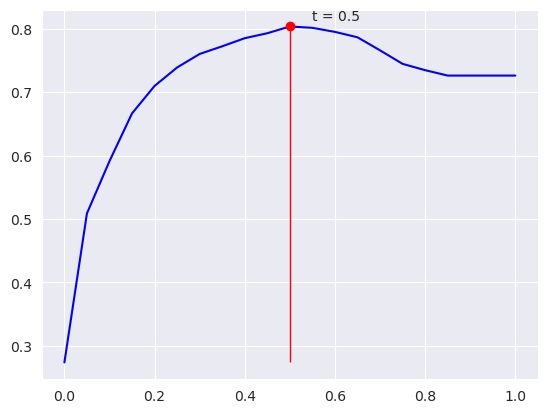

In [66]:
thresholds = np.linspace(0, 1, 21)

scores = np.zeros((len(thresholds), 2))

for i, t in enumerate(thresholds):
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    scores[i] = [t, score]

# Get threshold by best score
best_score = scores[:, -1].argmax()
result = scores[best_score]
print(result)

plt.plot(scores[:, 0], scores[:, 1], color='b')
plt.plot(result[0], result[1], 'ro') 
plt.text(result[0] + 0.05, result[1] + 0.01, s=f"t = {result[0]}")
plt.vlines(result[0], ymin=scores[:, -1].min(), ymax=result[1], color="red", linewidth=1)
plt.show()

The `scikit-learn` version of computing the accuracy

In [67]:
from sklearn.metrics import accuracy_score

In [69]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

[0.5        0.80340667]


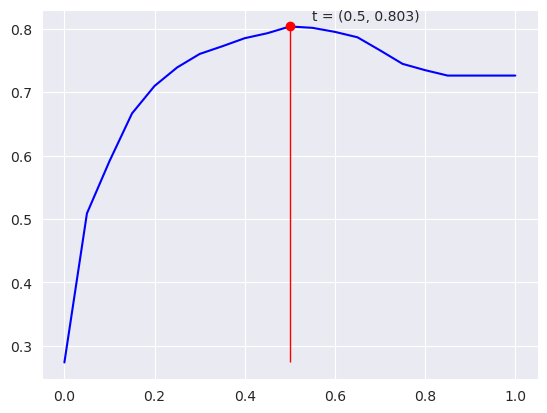

In [74]:
thresholds = np.linspace(0, 1, 21)

scores = np.zeros((len(thresholds), 2))

for i, t in enumerate(thresholds):
    score = accuracy_score(y_val, y_pred >= t)
    scores[i] = [t, score]

# Get threshold by best score
best_score = scores[:, -1].argmax()
result = scores[best_score]
print(result)

plt.plot(scores[:, 0], scores[:, 1], color='b')
plt.plot(result[0], result[1], 'ro') 
plt.text(result[0] + 0.05, result[1] + 0.01, s=f"t = {(result[0], np.round(result[1], 3))}")
plt.vlines(result[0], ymin=scores[:, -1].min(), ymax=result[1], color="red", linewidth=1)
plt.show()

**Interpretation of leftmost and rightmost thresholds**

In [75]:
from collections import Counter

In [78]:
print(Counter(y_pred >= 1.0)) # Everything is False
print(Counter(y_pred >= 0.0)) # Everything is True

Counter({False: 1409})
Counter({True: 1409})


The model, that classifies every customer of non-churning still has an accuracy of about $73\%$. This model is the dummy model.

The distrivution of labels in the target variable

In [82]:
print(Counter(y_val))

print(f"Churning: {y_val.mean():.3f}")
print(f"Non Churning: {1 - y_val.mean():.3f}")


Counter({0: 1023, 1: 386})
Churning: 0.274
Non Churning: 0.726


There are much more non-churning customers. This class-imbalance is detrimental to the effectiveness of the accuracy metric.